# 1) Set up

* import necessary modules
* locate filepath of data

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# 2) Sample Data
* use pandas to turn csv into dataframe
* view first 5 rows to get a feel for the data



In [ ]:
# read data in from csv
speech_data = pd.read_csv("/content/parkinson_sp.csv")
speech_data.head() # display first 5 rows

,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,MDVP:APQ,Shimmer:DDA,NHR,HNR,RPDE,DFA,spread1,spread2,D2,PPE,status
0,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,0.426,0.02182,0.03130,0.02971,0.06545,0.02211,21.033,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654,1
1,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,0.626,0.03134,0.04518,0.04368,0.09403,0.01929,19.085,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674,1
2,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,0.482,0.02757,0.03858,0.03590,0.08270,0.01309,20.651,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634,1
3,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,0.517,0.02924,0.04005,0.03772,0.08771,0.01353,20.644,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975,1
4,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,0.584,0.03490,0.04825,0.04465,0.10470,0.01767,19.649,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335,1


# 3) Data Processing
* training data is used to train the model
* cross validation is used to make sure we're not overfitting the data
* test set is to make predictions on

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer

# form X matrix of data and y vector of outcomes
X = speech_data.copy()
y = X.pop('status') # pop last column off from X

# normalise X so all features are within similar range
preprocessor = make_column_transformer((StandardScaler(),list(X.columns)))

# split into training, cross validation set
X_train, X_valid, y_train, y_valid = \
    train_test_split(X, y, stratify=y, train_size=0.7) #stratify makes sure classes are represented evenly across splits

# split cross validation set into cross val and test set
X_valid, X_test, y_valid, y_test = \
    train_test_split(X_valid, y_valid, stratify=y_valid, train_size=0.8)

X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
X_test = preprocessor.transform(X_test)
print(X_train.shape)
input_shape = [X_train.shape[1]] # gives number of features == number of input nodes

(136, 22)


# 4) Define Network Architecture
* 4 Dense hidden layers
* each dense layer is normalized
* each layer has 10% of nodes dropped out
* final layer uses sigmoid activation function --> 0 or 1

In [ ]:
# use keras to define network architecture
model = keras.Sequential([
    layers.Dense(256,activation="relu",input_shape=input_shape), # hidden layer 1 with 70 nodes and relu activation fnc
    layers.BatchNormalization(), # normalize hidden layer --> more stability
    layers.Dropout(0.1), # randomly drop 10% of nodes to prevent overfitting
    layers.Dense(64,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(64,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(32,activation="relu"), # same as before
    layers.BatchNormalization(), #same as before
    layers.Dropout(0.1),
    layers.Dense(1,activation="sigmoid") # binary output so only 1 output node, activation function is sigmoid
])


# 5) compile the model
* using "adam" optimizing algorithm which uses stochastic gradient descent
* using cross entropy loss function which defines probablity
* also define accuracy metrics

In [ ]:
# compile model with optimizing algorithm, loss function and accuracy function
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["binary_accuracy"])
# initialize the initial learning rate, number of epochs to train for,
# and batch size


# 6) Train the model
* use early stopping call back to prevent overfitting

Epoch 1/100
17/17 - 1s - loss: 0.7897 - binary_accuracy: 0.5662 - val_loss: 0.6309 - val_binary_accuracy: 0.7660 - 1s/epoch - 84ms/step
Epoch 2/100
17/17 - 0s - loss: 0.6167 - binary_accuracy: 0.7059 - val_loss: 0.5609 - val_binary_accuracy: 0.7872 - 87ms/epoch - 5ms/step
Epoch 3/100
17/17 - 0s - loss: 0.4695 - binary_accuracy: 0.8015 - val_loss: 0.5091 - val_binary_accuracy: 0.8298 - 75ms/epoch - 4ms/step
Epoch 4/100
17/17 - 0s - loss: 0.5358 - binary_accuracy: 0.8015 - val_loss: 0.4882 - val_binary_accuracy: 0.8298 - 99ms/epoch - 6ms/step
Epoch 5/100
17/17 - 0s - loss: 0.4596 - binary_accuracy: 0.8309 - val_loss: 0.4714 - val_binary_accuracy: 0.8298 - 97ms/epoch - 6ms/step
Epoch 6/100
17/17 - 0s - loss: 0.4364 - binary_accuracy: 0.7941 - val_loss: 0.4742 - val_binary_accuracy: 0.8298 - 90ms/epoch - 5ms/step
Epoch 7/100
17/17 - 0s - loss: 0.4293 - binary_accuracy: 0.8309 - val_loss: 0.4706 - val_binary_accuracy: 0.8085 - 95ms/epoch - 6ms/step
Epoch 8/100
17/17 - 0s - loss: 0.3686 - bi

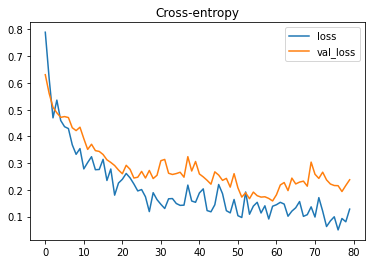

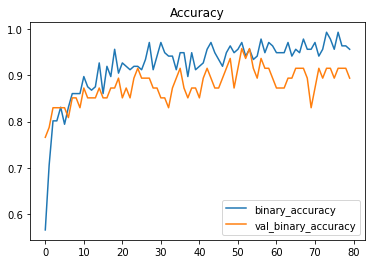

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=20,
    min_delta=0.001,
    restore_best_weights=True,
)
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=8,
    epochs=100,
    callbacks=[early_stopping],
    verbose=2
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

# 7) Use parameters learnt by model to make predictions on test set

In [ ]:
predictions = [round(x[0]) for x in model.predict(X_test)]
y = [x for x in y_test]
num_true = 0
total = len(predictions)
print(total)
for i in range(len(predictions)):
    if predictions[i] == y[i]:
        num_true += 1
accuracy = (num_true/total)*100

print("Percent of correct predictions: {}%".format(accuracy))

12
Percent of correct predictions: 91.66666666666666%
